# **Importing Libraries**

In [ ]:
#EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Crossvaluation, Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from tensorflow.keras.metrics import Precision, Recall

# ML Model
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#DL Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Loading DataFrame**

In [ ]:
df = pd.read_csv('/content/Hamspam-1.csv', encoding='latin-1')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5559 entries, 0 to 5558
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    5559 non-null   object
 1   text    5559 non-null   object
dtypes: object(2)
memory usage: 87.0+ KB


In [ ]:
df.rename(columns={'type': 'target'}, inplace = True)
df.head()

,target,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or å£10,000..."
4,spam,okmail: Dear Dave this is your final notice to...


# **Data Exploration**

In [ ]:
df['char_count'] = df['text'].str.len()
df['word_count'] = df['text'].apply(nltk.word_tokenize).str.len()
df['sentence_count'] = df['text'].apply(nltk.sent_tokenize).str.len()

<Figure size 1500x800 with 0 Axes>

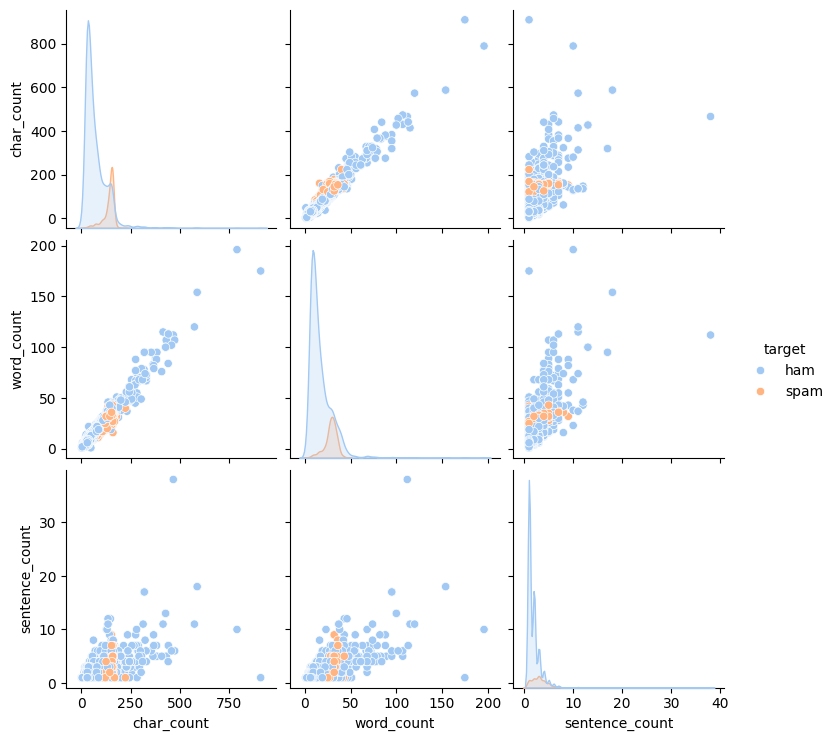

In [ ]:
plt.figure(figsize=(15,8))
sns.pairplot(df, hue= 'target', palette= 'pastel')
plt.show()

## **Handling Outliers**

In [ ]:
df = df.query('char_count < 400')

<Figure size 1500x800 with 0 Axes>

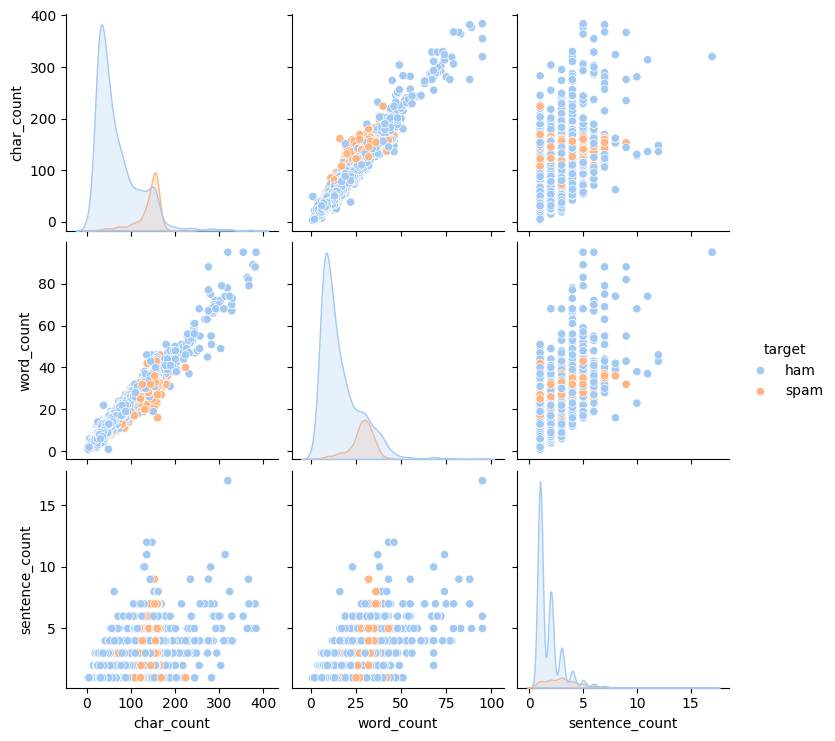

In [ ]:
plt.figure(figsize=(15,8))
sns.pairplot(df, hue= 'target', palette= 'pastel')
plt.show()

In [ ]:
df.shape

(5542, 5)

# **Feature Engineering**


* ## Tokenization
* ## Removing Stopwords
* ## Stemming & Lemmatization

In [ ]:
print(df['text'][:5])

0    Hope you are having a good week. Just checking in
1                              K..give back my thanks.
2          Am also doing in cbe only. But have to pay.
3    complimentary 4 STAR Ibiza Holiday or å£10,000...
4    okmail: Dear Dave this is your final notice to...
Name: text, dtype: object


In [ ]:
text = "The quick brown fox jumps over the lazy dog."
tokens = nltk.word_tokenize(text)

tagged_tokens = nltk.pos_tag(tokens)
print(tagged_tokens)

[('The', 'DT'), ('quick', 'JJ'), ('brown', 'NN'), ('fox', 'NN'), ('jumps', 'VBZ'), ('over', 'IN'), ('the', 'DT'), ('lazy', 'JJ'), ('dog', 'NN'), ('.', '.')]


In [ ]:
# Mapping nltk [Position Tags] to WordNet [Position Tags]
def get_pos_tag(tag):
    pos_map = {'NN': 'n', 'VB': 'v', 'JJ': 'a', 'RB': 'r'}
    return pos_map.get(tag[:2], 'n')

def process_text(text):
    ps = PorterStemmer()
    lmr = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Tokenizing text, getting POS tags
    tokens = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    token_tag = nltk.pos_tag(tokens)

    processed_words = []
    for word, tag in token_tag:
        if word not in stop_words:
          if tag.startswith('NN'):  # Apply stemming to nouns
                stemmed_word = ps.stem(word)
                processed_words.append(stemmed_word)
          else:  # Apply lemmatization to other POS
                pos = get_pos_tag(tag)
                lemmatized_word = lmr.lemmatize(word, pos=pos)
                processed_words.append(lemmatized_word)

    # Join processed words into a string
    processed_words = ' '.join(processed_words)

    return processed_words


In [ ]:
df['processed_text'] = df['text'].apply(process_text)

In [ ]:
df['processed_text']

,processed_text
0,hope good week check
1,k give back thank
2,also cbe pay
3,complimentary star ibiza holiday cash need urg...
4,okmail dear dave final notic collect tenerif h...
...,...
5554,great role model give much really wish day mir...
5555,awesom remember last time get somebody high fi...
5556,prize go another custom c www c biz p min polo...
5557,sm ac jsco energi high u may know channel day ...


# **Vectorization**

In [ ]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['processed_text'])

X = tfidf_matrix.toarray()

In [ ]:
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

y = df['target']

In [ ]:
X.dtype

dtype('float64')

# **Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=10, shuffle= True, stratify=y)

# **Model Building**

In [ ]:
classifiers = [
    KNeighborsClassifier(),
    MultinomialNB(),
    SVC(),
    RandomForestClassifier(),
    ]

for model in classifiers:
  model.fit(X_train,y_train)

pipeline_dict= {0:'KNeighbors', 1:'NaiveBayes', 2:'SVC', 3:'RandomForest'}

## **Model Evaluation**

In [ ]:
for i, model in enumerate(classifiers):
  cv_score = cross_val_score(model,X_train,y_train,scoring='accuracy',cv=5)
  mean_accuracy = sum(cv_score)/len(cv_score)
  mean_accuracy = mean_accuracy*100
  mean_accuracy = round(mean_accuracy,2)
  print(f'{pipeline_dict[i]}: {mean_accuracy}')

KNeighbors: 90.4
NaiveBayes: 95.91
SVC: 97.31
RandomForest: 97.38


In [ ]:
precision = []
recall = []
f1_scores = []
training_accuracy = []
testing_accuracy = []

for c in classifiers:
  test_pred = c.predict(X_test)
  prec = precision_score(y_test, test_pred)
  precision.append(prec)
  rec = recall_score(y_test, test_pred)
  recall.append(rec)
  f1_s = f1_score(y_test, test_pred)
  f1_scores.append(f1_s)
  train_accuracy = model.score(X_train,y_train) * 100
  training_accuracy.append(train_accuracy)
  test_accuracy = model.score(X_test,y_test)  * 100
  testing_accuracy.append(test_accuracy)

# **Prediction Result**

In [ ]:
data = {
    'Model': pipeline_dict.values(),
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_scores,
    'Training Accuracy': training_accuracy,
    'Testing Accuracy': testing_accuracy
}

results = pd.DataFrame(data)
results

,Model,Precision,Recall,F1 Score,Training Accuracy,Testing Accuracy
0,KNeighbors,1.0000,0.363636,0.533333,100.0,97.763348
1,NaiveBayes,1.0000,0.721925,0.838509,100.0,97.763348
2,SVC,1.0000,0.828877,0.906433,100.0,97.763348
3,RandomForest,0.9875,0.844920,0.910663,100.0,97.763348


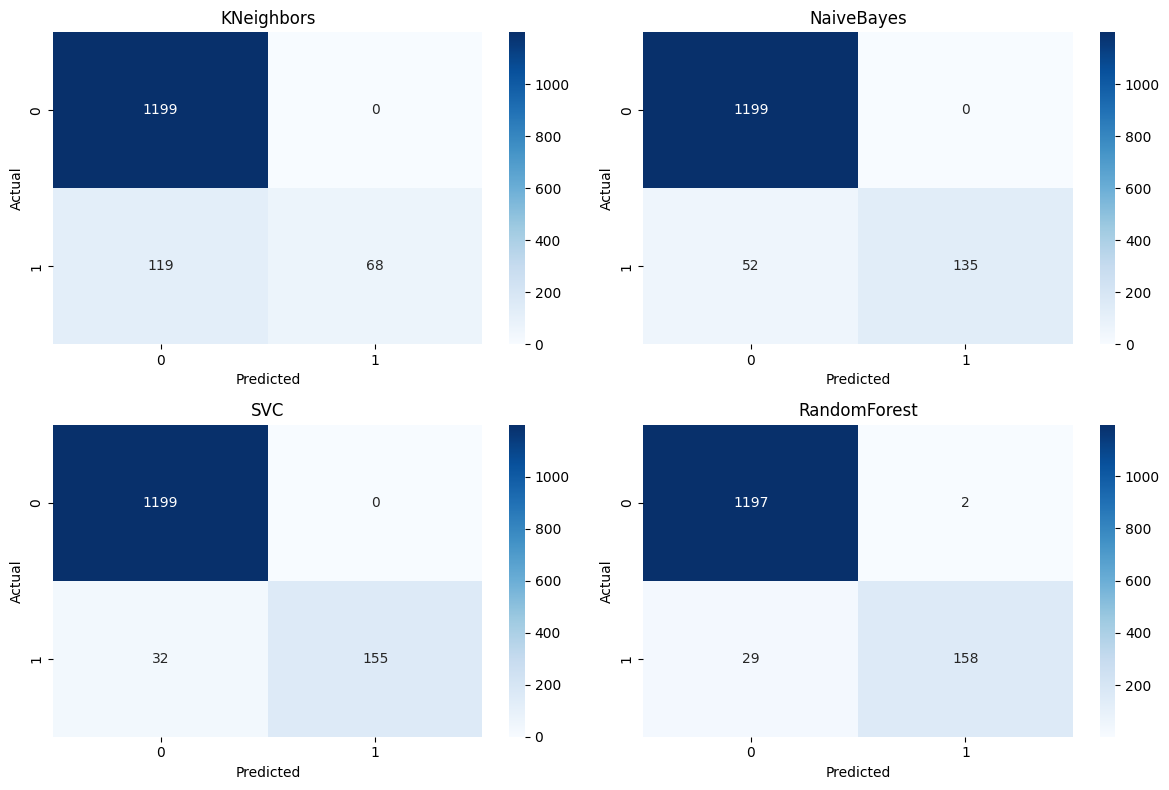

In [ ]:
cls = [pipeline_dict[i] for i in pipeline_dict]
test_preds = [model.predict(X_test) for model in classifiers]

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Plot each confusion matrix
for i, (ax, test_preds) in enumerate(zip(axes.flatten(), test_preds)):
    cm = confusion_matrix(y_test, test_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(cls[i])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# **DL Model Building**

## Data Reshape

In [ ]:
X_new = X.reshape((X.shape[0], 1, X.shape[1]))
X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state=10, shuffle= True, stratify=y)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units = 128, input_shape = (X_new_train.shape[1], X_new_train.shape[2]), return_sequences= False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(units = 1, activation= 'sigmoid'))

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

print(lstm_model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │       3,437,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,437,185 (13.11 MB)

 Trainable params: 3,437,185 (13.11 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
lstm_model.fit(X_new_train, y_train, epochs=10, batch_size=64, validation_data=(X_new_test, y_test))

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8488 - loss: 0.6413 - precision: 0.2096 - recall: 0.0421 - val_accuracy: 0.8687 - val_loss: 0.4415 - val_precision: 1.0000 - val_recall: 0.0267
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8791 - loss: 0.3707 - precision: 1.0000 - recall: 0.1179 - val_accuracy: 0.9040 - val_loss: 0.2393 - val_precision: 1.0000 - val_recall: 0.2888
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9259 - loss: 0.1910 - precision: 0.9993 - recall: 0.4402 - val_accuracy: 0.9459 - val_loss: 0.1566 - val_precision: 0.9912 - val_recall: 0.6043
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9627 - loss: 0.1217 - precision: 0.9958 - recall: 0.7225 - val_accuracy: 0.9654 - val_loss: 0.1131 - val_precision: 0.9929 - val_recall: 0.7487
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.9838 - loss: 0.0733 - precision: 0.9976 - recall: 0.8809 - val_accuracy: 0.9726 - val_loss: 0.0911 

# **Model Evaluation**



In [ ]:
loss, accuracy, precision_val, recall_val = lstm_model.evaluate(X_new_test, y_test)
lstm_f1_score = 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-7)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1 Score: {lstm_f1_score: .4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0761 - precision: 0.9987 - recall: 0.8562
Test Loss: 0.0643
Test Accuracy: 98.3405
Precision: 0.9940
Recall: 0.8824
F1 Score:  0.9348


In [ ]:
def binary_coder(value, threshold=0.5):
    return 1 if value >= threshold else 0


lstm_train_predictions = lstm_model.predict(X_new_train)
lstm_train_predictions = np.apply_along_axis(binary_coder, 1, lstm_train_predictions)
lstm_train_acc = accuracy_score(y_train, lstm_train_predictions)*100

130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [ ]:
new_row = {'Model': 'LSTM', 'Precision': precision_val, 'Recall': recall_val, 'F1 Score': lstm_f1_score,'Training Accuracy': lstm_train_acc, 'Testing Accuracy': accuracy*100}
results = pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)

# **Final Result**

In [ ]:
results

,Model,Precision,Recall,F1 Score,Training Accuracy,Testing Accuracy
0,KNeighbors,1.000000,0.363636,0.533333,100.000000,97.763348
1,NaiveBayes,1.000000,0.721925,0.838509,100.000000,97.763348
2,SVC,1.000000,0.828877,0.906433,100.000000,97.763348
3,RandomForest,0.987500,0.844920,0.910663,100.000000,97.763348
4,LSTM,0.993976,0.882353,0.934844,99.735322,98.340547
